In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import regression_funs as rfu


## constants and functions

In [524]:

PATH_TO_FILE = '../data_in/flexpart-mosaic-data_alias/AIRTRACER_100m.nc'

PATH_TO_SO2 = '../data_in/flexpart-mosaic-data_alias/MSAQSO2L4_2005-2018_v01-04_20190314.h5'

PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

PATH_TO_BC = '../data_in/black_carbon_channel6_masked_5min.csv'
# PATH_TO_BC = '../data_in/black_carbon_channel6_raw_5min.csv'

PATH_1000_CLUS = '../data_out/cluster1000.nc'

LA = 'lat'
LO = 'lon'
TI = 'time'
AG = 'age'
AT = 'AIRTRACER'
L = 'lab'
CM = 'tab20'

SA = 'sa'
MSA = 'msa'
IA = 'ia'

BC = 'bc_masked_ngm3'

# BC = 'bc_raw_ngm3'

LBC = 'log(bc)'

LSA = 'log10(sa)'
LMSA = 'log10(msa)'
LIA = 'log10(ia)'

COLS = [SA, MSA, IA]
LCOLS = [LSA, LMSA, LIA]

DATA_OUT = '../data_out'

COL = plt.get_cmap('Dark2')

DC = {
    SA  : COL(0),
    MSA : COL(1),
    IA  : COL(2),
    LSA : COL(0),
    LMSA: COL(1),
    LIA : COL(2),
    BC  : COL(3),
    LBC : COL(3)
}

In [654]:
PAR=MSA

In [655]:
df = pd.read_csv(PATH_TO_ST, index_col=0, parse_dates=True)
(df[PAR]>0).value_counts()

True     27170
False      231
Name: msa, dtype: int64

In [656]:
df = df[df[PAR]>0][[PAR]]

In [657]:
df

,msa
time,
2019-10-20 02:55:00,471655.500000
2019-10-20 03:05:00,397632.562500
2019-10-20 03:15:00,398285.281250
2019-10-20 03:25:00,540646.187500
2019-10-20 03:45:00,603345.437500
...,...
2020-10-01 08:05:00,26403.804688
2020-10-01 08:15:00,58329.910156
2020-10-01 08:20:00,30199.201172


In [658]:
q1,q2 = df[PAR].quantile([.001,.999])

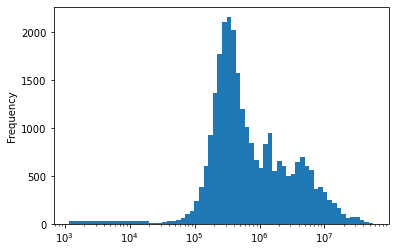

In [659]:
df[PAR].plot.hist(bins=[df[PAR].min()-1,*np.geomspace(q1,q2)])
plt.gca().set_xscale('log')

In [660]:
df=df[df[PAR]>0]

(19533.186201171877, 56643067.98000085)

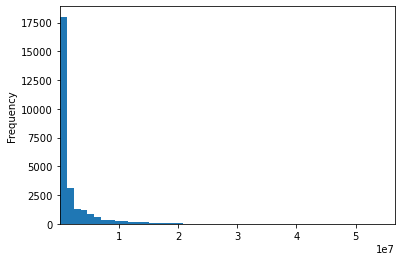

In [661]:
p = (df[PAR]**1)
q1,q2 = p.quantile([.001,.999])
p.plot.hist(bins=np.linspace(q1,q2))
ax = plt.gca()
ax.set_xlim(q1,q2)

(19.374459808470604, 211.8086271821241)

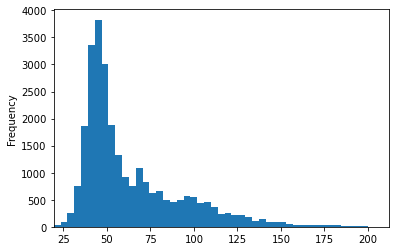

In [662]:
p = (df[PAR]**.3)
q1,q2 = p.quantile([.001,.999])
p.plot.hist(bins=np.linspace(q1,q2))
ax = plt.gca()
ax.set_xlim(q1,q2)

In [663]:
# df[LBC] = np.log10(df[PAR])

# distributions


lets find what kind of dist. do we have. They seem to be log dists.

Text(0.5, 0, 'log10')

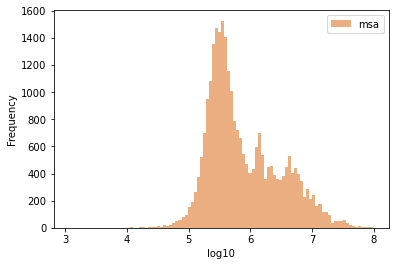

In [664]:
for c in [PAR]:
    np.log10(df[c]).plot.hist(alpha=.5, bins=100, label=c, color=DC[c])
ax = plt.gca()
ax.legend()
ax.set_xlabel('log10')

# timeseries of the trace gases

# open and merge flex 1000 clusters

In [665]:
ds = xr.open_dataset(PATH_1000_CLUS)

In [666]:
dsf = ds.groupby(L).sum().to_dataframe()[AT].unstack(L)

In [667]:
dsf.sum()

lab
0      117.893692
1      116.569145
2       99.189194
3       98.726097
4       90.979523
          ...    
995      0.544238
996      0.526847
997      0.512809
998      0.465698
999      0.453642
Length: 1000, dtype: float32

In [668]:
from sklearn.preprocessing import RobustScaler

In [669]:
RS = RobustScaler(
    with_centering=False,
    with_scaling=True,
    quantile_range=(25.0, 75.0),
    copy=True,
    unit_variance=False,
)

In [670]:
dsf2 = dsf/np.sqrt((dsf**2).sum())

In [671]:
dsf2.sum()

lab
0      15.317408
1      11.129049
2      10.441088
3      11.637880
4      14.796584
         ...    
995    30.548052
996    31.100914
997    30.608913
998    30.391745
999    32.368301
Length: 1000, dtype: float32

In [672]:
df1 = df[[PAR]]

In [673]:
df2 = df1.resample('3H').median()
df3 = df2[~df2[PAR].isna()]

In [674]:
dm = pd.merge(df3, dsf2, left_index=True, right_index=True, how='inner', validate="1:1")

# Linear Regression

In [675]:
from sklearn.linear_model import ElasticNetCV,ElasticNet, LinearRegression

In [676]:
lreg = LinearRegression(
    fit_intercept=False,
    normalize='deprecated',
    copy_X=True,
    n_jobs=None,
    positive=True,
)

In [677]:
X = dm[dsf2.columns]
y = dm[PAR]
lreg.fit(X,y)
y_pred = lreg.predict(X)

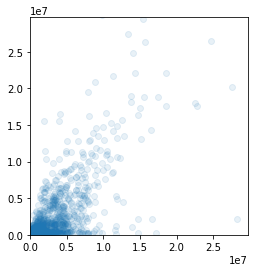

In [678]:
plt.scatter(y_pred,y,alpha=.1)
ax=plt.gca()
ax.set_xlim(0,y.quantile(.99))
ax.set_ylim(0,y.quantile(.99))
ax.set_aspect('equal')

<AxesSubplot:xlabel='time'>

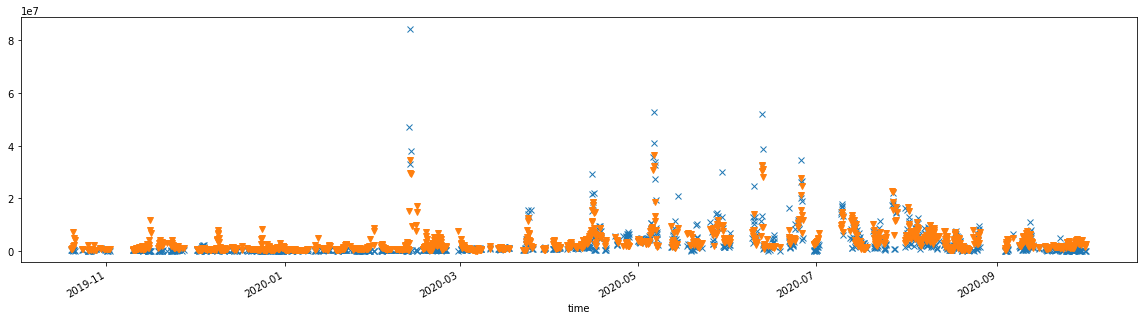

In [679]:
f,ax = plt.subplots(figsize=(20,5))
y.plot(lw=0,marker='x')
(y*0 + y_pred).plot(lw=0,marker='v')

In [680]:
tot_sd = (y**2).sum()**.5

In [681]:
exp_sd = ((y-y_pred)**2).sum()**.5

In [682]:
best_sd = exp_sd/tot_sd
best_sd

0.5649802670699394

In [683]:
np.corrcoef(y,y_pred)[0,1]**2

0.6297685740058092

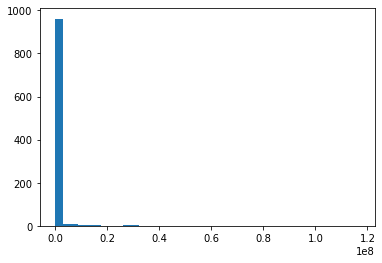

In [684]:
plt.hist(lreg.coef_,bins=40);

# Elastic net regression cross validated

$L_{\text {enet }}(\hat{\beta})=\frac{\sum_{i=1}^{n}\left(y_{i}-x_{i}^{\prime} \hat{\beta}\right)^{2}}{2 n}+\lambda\left(\frac{1-\alpha}{2} \sum_{j=1}^{m} \hat{\beta}_{j}^{2}+\alpha \sum_{j=1}^{m}\left|\hat{\beta}_{j}\right|\right)$

In [685]:
e_reg_cv=ElasticNetCV(
    l1_ratio=[.1,0.5,0.7,.9,.99,.999,.9999,.99999,.999999,.9999999],
    eps=0.001,
    n_alphas=100,
    alphas=None,
    fit_intercept=False,
    normalize='deprecated',
    precompute='auto',
    max_iter=1000,
    tol=0.0001,
    cv=5,
    copy_X=True,
    verbose=0,
    n_jobs=None,
    positive=True,
    random_state=None,
    selection='cyclic',
)

In [686]:
X = dm[dsf2.columns]
y = dm[PAR]
e_reg_cv.fit(X,y)
y_pred = e_reg_cv.predict(X)

In [687]:
exp_sd = ((y-y_pred)**2).sum()**.5

In [688]:
exp_sd/tot_sd

0.7129654974941849

In [689]:
cv_a = e_reg_cv.alpha_
cv_a

174.13010627593974

In [690]:
cv_l1 = e_reg_cv.l1_ratio_
cv_l1

0.99999

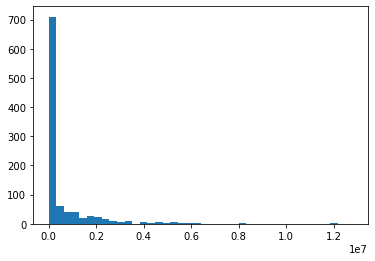

In [691]:
plt.hist(e_reg_cv.coef_,bins=40);

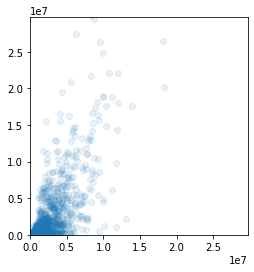

In [692]:
plt.scatter(y_pred,y,alpha=.1)
ax=plt.gca()
ax.set_xlim(0,y.quantile(.99))
ax.set_ylim(0,y.quantile(.99))
ax.set_aspect('equal')

<AxesSubplot:xlabel='time'>

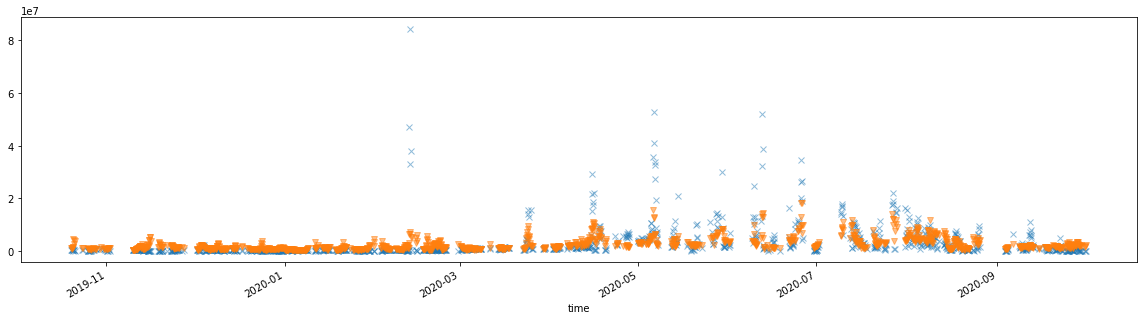

In [693]:
f,ax = plt.subplots(figsize=(20,5))
y.plot(lw=0,marker='x',alpha=.5)
(y*0 + y_pred).plot(lw=0,marker='v',alpha=.5)

alpha = a + b and l1_ratio = a / (a + b)

In [694]:
cv_a

174.13010627593974

In [695]:
B = cv_a * (1-cv_l1)
B

0.0017413010627514726

In [696]:
A = cv_a - B
A

174.12836497487697

# selection

In [697]:
def elastic_net(_a, _l1, dsf2, dm, PAR,tot_sd):
    e_reg = ElasticNet(
        alpha=_a,
        l1_ratio=_l1,
        fit_intercept=False,
        normalize='deprecated',
        precompute=False,
        max_iter=10000,
        copy_X=True,
        tol=0.0001,
        warm_start=False,
        positive=True,
        random_state=None,
        selection='cyclic',
    )

    X = dm[dsf2.columns]
    y = dm[PAR]
    e_reg.fit(X, y)
    y_pred = e_reg.predict(X)



    exp_sd = ((y - y_pred) ** 2).sum() ** .5

    ratio = exp_sd / tot_sd

    coef = X.sum().T * 0 + e_reg.coef_
    return coef, ratio, exp_sd

In [698]:
g = []
def to_min(fac):
    global g 

    nA = fac*A

    _a = B + nA 

    _l1 = nA/(nA + B)


    coef, ratio, exp_sd = elastic_net(_a, _l1, dsf2, dm, PAR,tot_sd)
#     print(ratio)
    g.append([ratio,fac])

    return np.abs(ratio - .999)

In [699]:
from scipy.optimize import minimize_scalar

In [703]:
res = minimize_scalar(to_min,method='Bounded',bounds=(1,300))

In [704]:
g

[[0.9878276692016555, 229.79764073881296],
 [1.0, 371.202359261187],
 [1.0, 458.5952814776259],
 [1.0, 414.89882036940645],
 [1.0, 398.2082574141545],
 [1.0, 387.89292221643893],
 [1.0, 381.51769445890255],
 [1.0, 377.5775870187233],
 [1.0, 375.14246670136623],
 [1.0, 373.6374795785441],
 [1.0, 372.7073463840091],
 [1.0, 372.13249245572194],
 [1.0, 371.7772131894741],
 [1.0, 371.5576385274348],
 [1.0, 371.4219339232263],
 [1.0, 371.33806386539555],
 [1.0, 371.2862293190177],
 [1.0, 371.2541938075648],
 [1.0, 371.2343947726399],
 [1.0, 371.2221582961119],
 [1.0, 371.214595737715],
 [1.0, 371.2099218195838],
 [1.0, 371.20703317931816],
 [1.0, 371.2052479014527],
 [1.0, 371.2041445390525],
 [1.0, 371.20346262358726],
 [1.0, 371.2030411766523],
 [1.0, 371.20278070812196],
 [1.0, 371.20261972971724],
 [1.0, 371.2025202395917],
 [1.0, 371.2024587513126],
 [1.0, 371.20242074946617],
 [1.0, 371.20239726303345],
 [1.0, 371.2023827476197],
 [1.0, 371.20237377660067],
 [0.8737222286187805, 115.20

In [705]:
res

     fun: 1.2671693694343844e-09
 message: 'Solution found.'
    nfev: 27
  status: 0
 success: True
       x: 276.6030515481822

In [706]:
aas = np.linspace(1,res.x,100)

In [707]:
coef, ratio, exp_sd = elastic_net(_a, _l1, dsf2, dm, PAR,tot_sd)

In [708]:
dic = {}
for aa in aas[::-1]:
#     print(aa)
    d2 = {}
    nA = aa * A
#     print(aa)

    _a = B + nA 

    _l1 = nA/(nA + B)


    coef, ratio, exp_sd = elastic_net(_a, _l1, dsf2, dm, PAR,tot_sd)

#     inn=coef[coef>0].index


#     e_reg_cv=ElasticNetCV(
#         l1_ratio=0.001,
#         eps=0.001,
#     #     n_alphas=100,
#         alphas=[.0001,.001,.01,.1,1,10,100,1000,10000],
#         fit_intercept=False,
#         normalize='deprecated',
#         precompute='auto',
#         max_iter=10000000,
#         tol=0.0001,
#         cv=5,
#         copy_X=True,
#         verbose=0,
#         n_jobs=None,
#         positive=True,
#         random_state=None,
#         selection='cyclic',
#     )

#     X = dm[inn]
#     y = dm[PAR]
#     e_reg_cv.fit(X, y)
#     y_pred = e_reg_cv.predict(X)

#     exp_sd = ((y - y_pred) ** 2).sum() ** .5

#     ratio = exp_sd / tot_sd

#     coef = X.sum().T * 0 + e_reg_cv.coef_

    d2['coef'] = coef
    d2['ratio'] = ratio
    d2['exp_sd'] = exp_sd
    dic[aa] = d2
        


In [709]:
dk = {}
for k,r in dic.items():
    dk[k] = r['coef'].to_dict()
ddf = pd.DataFrame(dk).T

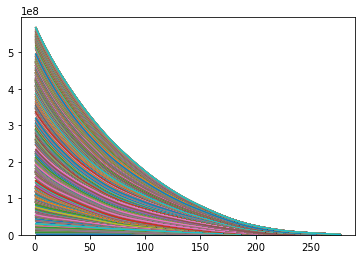

In [710]:

ddf.plot.area()
ax = plt.gca()
ax.get_legend().remove()

<AxesSubplot:>

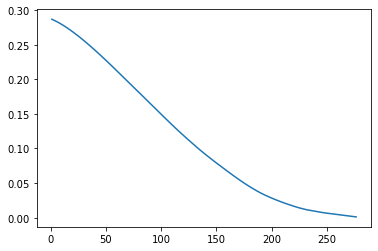

In [711]:
dk = {}
for k,r in dic.items():
    dk[k] = 1-r['ratio']
pd.Series(dk).plot()

In [712]:
dk = {}
for k,r in dic.items():
    dk[1-dic[k]['ratio']] = r['coef'].to_dict()
ddf = pd.DataFrame(dk).T

In [713]:
la = []
rr = []
# lr = {0.1+i/100000:0 for i in range(1,100)}
lr = {0:0}
# lr = {}
for l,r in ddf[::].iterrows():
    ii = r[r>0].index
    bo = ~ii.isin(la)
    la = [*la,*list(ii[bo])]
    rr = [*rr,*r[list(ii[bo])].values]
    lr[len(la)] = l
#     if len(la)>37: break
    
    

In [714]:
n_sd = pd.Series(lr)

In [715]:
n_sd

0      0.000000
2      0.006692
3      0.011302
5      0.013517
6      0.014710
         ...   
297    0.277439
309    0.280154
323    0.282676
342    0.284973
364    0.287035
Length: 76, dtype: float64

In [716]:
from pygam import LinearGAM, s

# X = np.log10(n_sd.reset_index()[['index']])
X = (n_sd.reset_index()[['index']])
y = n_sd

gam1 = LinearGAM(s(0, constraints='concave',n_splines=20,spline_order=3)).fit(X, y)
# gam1 = LinearGAM(s(0,n_splines=20,spline_order=3)).fit(X, y)

/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/pygam/pygam.py:752: RuntimeWarning: divide by zero encountered in reciprocal
  np.fill_diagonal(Dinv, d**-1) # invert the singular values


In [717]:
X1=10**X
X1=X

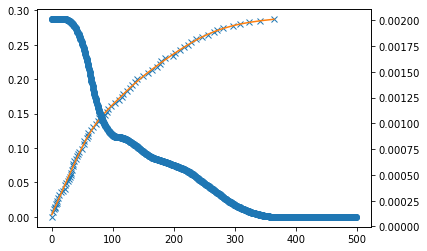

In [718]:
f,ax = plt.subplots()
ax.plot(X1,n_sd,lw=0,marker='x')
ax.plot(X1,gam1.predict(X))

def ffit(x): 
#     if x ==0:
#         return 0
#     else:
#         return gam1.predict([x])[0]
    return gam1.predict([x])[0]

from scipy.misc import derivative

x = np.arange(0,500,1)

y = [derivative(ffit,_) for _ in x ]

axx = ax.twinx()
axx.plot(x,y,lw=1,marker='o')
# axx.set_yscale('log')

In [719]:
ni = pd.Series(rr,index=la)

In [720]:
ni1 = ni[::-1].reset_index().reset_index().set_index('index')['level_0'].to_dict()
ni1 = ni[::].reset_index().reset_index().set_index('index')['level_0'].to_dict()

In [721]:
ni2 = {i:derivative(ffit,_)  for i,_ in ni1.items()}
ni2 = {i:ffit(_)  for i,_ in ni1.items()}

In [722]:
_ds = ds['lab'].to_series()

In [723]:
_ds1 = _ds.where(_ds.isin(ni2)).replace(ni2).to_xarray()

In [724]:
_ds1

<xarray.DataArray 'lab' (lat: 24, lon: 72)>
array([[0.05755318,        nan, 0.05354802, ..., 0.02342172, 0.00534328,
        0.26490624],
       [0.05755318,        nan, 0.17116162, ..., 0.02342172, 0.04752628,
        0.26490624],
       [0.05955124, 0.11012841, 0.14928103, ...,        nan, 0.04752628,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.28523569, 0.28523569, 0.28523569, ..., 0.26158835, 0.28565929,
        0.28565929],
       [0.2697172 ,        nan,        nan, ..., 0.2697172 , 0.2697172 ,
        0.2697172 ]])
Coordinates:
  * lat      (lat) float64 60.62 61.88 63.12 64.38 ... 85.62 86.88 88.12 89.38
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5

In [725]:
# plt.scatter(y_pred,y,alpha=.1)
# ax=plt.gca()
# ax.set_xlim(0,y.quantile(.99))
# ax.set_ylim(0,y.quantile(.99))
# ax.set_aspect('equal')

In [726]:
# f,ax = plt.subplots(figsize=(20,5))
# y.plot(lw=0,marker='x')
# (y*0 + y_pred).plot(lw=0,marker='v')

In [727]:
_ds2 = (_ds1/_ds1.max())**10
_ds2 = _ds1/_ds1.max()
_ds2 = _ds1

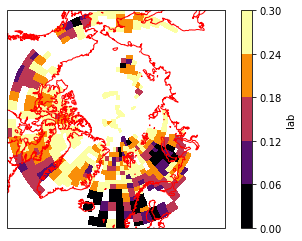

In [728]:
# inn = coef[coef>0].index

# pl = ds['lab'].where(ds['lab'].isin(inn))* 0 + 1




import cartopy.crs as ccrs
ax = plt.subplot(projection=ccrs.Orthographic(0, 90), facecolor='w')
(_ds2).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    robust=True,
    levels=6,
    cmap='inferno',
#     vmin=0,

)
ax.coastlines(color='red')

In [653]:
ds

<xarray.Dataset>
Dimensions:    (lon: 72, lat: 24, time: 3021)
Coordinates:
  * lon        (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * lat        (lat) float64 60.62 61.88 63.12 64.38 ... 85.62 86.88 88.12 89.38
  * time       (time) datetime64[ns] 2019-09-20T09:00:00 ... 2020-10-01T21:00:00
    lab        (lat, lon) int64 837 917 976 831 825 815 ... 463 294 294 294 294
Data variables:
    AIRTRACER  (time, lat, lon) float32 0.0004269 0.0001852 ... 0.0002132